In [2]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer
from sklearn.model_selection import train_test_split
import random
import tensorflow as tf

# Prepare training and testing data

In [3]:
with open('../../Datasets/normalized_banknote.csv') as f:
    temp = np.loadtxt(f, delimiter=',', skiprows=1)

X = temp[:,:-1]
y = temp[:,-1]
y = np.tensor([-1 if i == 0 else 1 for i in y])
feats_train, feats_test, Y_train, Y_test = train_test_split(X, y,train_size=0.7,random_state=42)


In [4]:
X.shape

(1371, 4)

In [5]:
y.shape

(1371,)

# define varational circuit

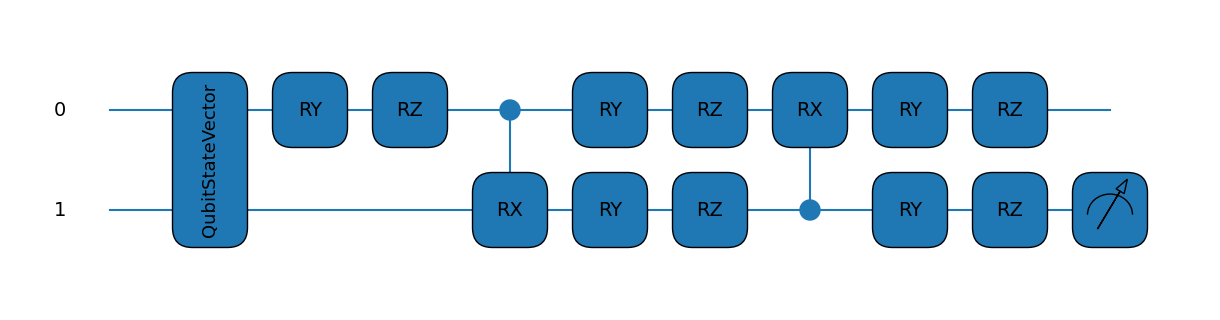

In [6]:
num_wires = 2
dev = qml.device("default.qubit", wires=num_wires)

@qml.qnode(dev, diff_method="backprop")
def circuit(feature_vector,weights=None):
    qml.AmplitudeEmbedding(features=feature_vector, wires=range(num_wires), pad_with=0,normalize=True)
    qml.RY(weights[0], wires=0)
    qml.RZ(weights[1], wires=0)

    qml.CRX(weights[2],wires=[0,1])
    qml.RY(weights[3], wires=0)
    qml.RZ(weights[4], wires=0)
    qml.RY(weights[5], wires=1)
    qml.RZ(weights[6], wires=1)

    qml.CRX(weights[7],wires=[1,0])
    qml.RY(weights[8], wires=0)
    qml.RZ(weights[9], wires=0)
    qml.RY(weights[10], wires=1)
    qml.RZ(weights[11], wires=1)
    return qml.expval(qml.PauliZ(wires=1))
weights = np.array([1.69783, -0.0349, 1.09658, -0.67087, 0.56437, 0.09912, 1.62751, 2.22998, 0.16848, 0.58332, 1.84687, 0.81434], requires_grad=True)
# weights = np.random.random(size=[12], requires_grad=True)
bias = np.array(0.15, requires_grad=True)
# bias = np.array(0.0, requires_grad=True)
fig, ax = qml.draw_mpl(circuit, expansion_strategy="device")(feats_train[0],weights)

In [7]:
def variational_classifier(weights, bias,feature_vector):
    return circuit( feature_vector,weights)+bias

def cost(weights, bias, features, labels):
    predictions = [variational_classifier(weights, bias,f) for f in features]
    loss = 0
    for l, p in zip(labels, predictions):
        loss +=  (l - p) ** 2
    return loss/ len(labels)

def accuracy(labels, predictions):
    success = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 0.5:
            success += 1
    return success/ len(labels)

In [9]:
opt = NesterovMomentumOptimizer(stepsize=0.02)

def mini_batch_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        j = tf.constant(indices[i:min(i + batch_size, num_examples)])
        yield tf.gather(features, j), tf.gather(labels, j)

num_epochs = 100
batch_size = 20
for epoch in range(num_epochs):
    for feats_train_batch, Y_train_batch in mini_batch_iter(batch_size, feats_train, Y_train):
        feats_train_batch = feats_train_batch.numpy()
        Y_train_batch = Y_train_batch.numpy()
        # Update the weights by one optimizer step
        weights, bias, _, _ = opt.step(cost, weights, bias,feats_train_batch , Y_train_batch)
    
    # Compute predictions on train and validation set
    predictions_train = [np.sign(variational_classifier(weights, bias, f)) for f in feats_train]
    predictions_val = [np.sign(variational_classifier(weights, bias, f)) for f in feats_test]
    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_test, predictions_val)
    print(
        "Epoch: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
        "".format(epoch + 1, cost(weights, bias, X, y), acc_train, acc_val)+str([ float("{:.5f}".format(elem)) for elem in weights.flatten().tolist() ])+str( float("{:.5f}".format(bias)))
    )

Epoch:     1 | Cost: 0.7607791 | Acc train: 0.7059437 | Acc validation: 0.6359223 [1.49543, 0.49149, 1.19755, -1.01924, 0.77596, 0.05155, 0.48962, 2.90956, 0.16848, 0.58332, 1.21496, 0.81434]0.00826
Epoch:     2 | Cost: 0.7670641 | Acc train: 0.7257560 | Acc validation: 0.6941748 [1.4692, 0.48465, 1.25795, -1.07313, 0.71157, 0.00564, 0.51977, 3.01962, 0.16848, 0.58332, 1.2029, 0.81434]0.13636
Epoch:     3 | Cost: 0.7580635 | Acc train: 0.7069864 | Acc validation: 0.6383495 [1.52546, 0.43702, 1.2763, -1.00761, 0.72837, 0.11658, 0.39847, 3.02293, 0.16848, 0.58332, 1.20933, 0.81434]0.01181
Epoch:     4 | Cost: 0.7547557 | Acc train: 0.7080292 | Acc validation: 0.6480583 [1.51454, 0.45527, 1.32202, -1.00321, 0.73633, 0.11014, 0.40531, 3.0285, 0.16848, 0.58332, 1.25221, 0.81434]0.03384
Epoch:     5 | Cost: 0.7675924 | Acc train: 0.6996872 | Acc validation: 0.6359223 [1.53382, 0.40913, 1.27881, -0.93902, 0.6981, 0.18431, 0.37764, 3.0498, 0.16848, 0.58332, 1.32748, 0.81434]-0.01283
Epoch:    

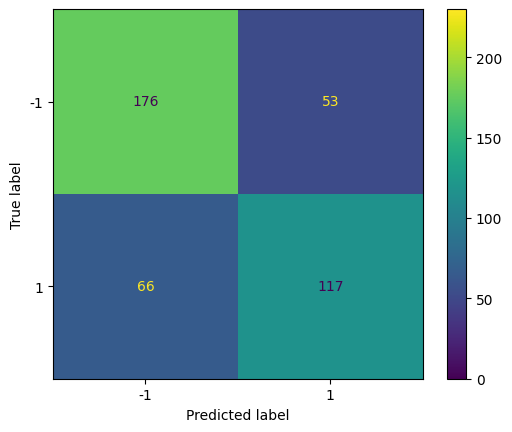

In [14]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

import matplotlib.pyplot as plt

predictions_test = [np.sign(variational_classifier(weights, bias, f)) for f in feats_test]

cm = confusion_matrix(Y_test, predictions_test, labels=[-1,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[-1,1])
disp.plot()
disp.im_.set_clim(0, 230)

plt.show()